2026-02-21 18:37:14,216 - src.models.churn_model - INFO - Model loaded from ../models/churn_model_rf.pkl
2026-02-21 18:37:14,261 - src.business.offer_recommender - INFO - Offer distribution:
RecommendedOffer
We miss you! 15% off your next order                             1104
Referral bonus: give $10, get $10                                 801
Standard monthly newsletter with personalized recommendations     651
Loyalty points multiplier (2x for next month)                     588
High-value at-risk: 25% off next purchase + free shipping         364
VIP exclusive event invitation + early access to new products     344
Welcome series: 10% off second purchase                           262
Flash sale preview (24h early access)                             144
Re-engagement email with 20% off                                   80
Name: count, dtype: int64
2026-02-21 18:37:14,261 - src.business.offer_recommender - INFO - Offer distribution:
RecommendedOffer
We miss you! 15% off your next or

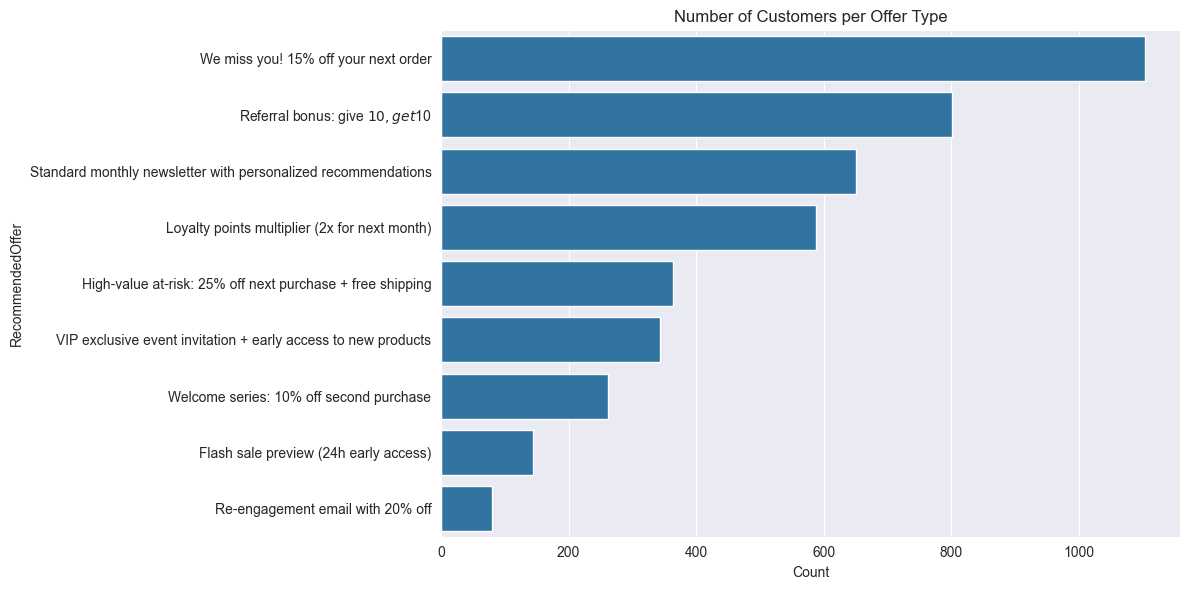

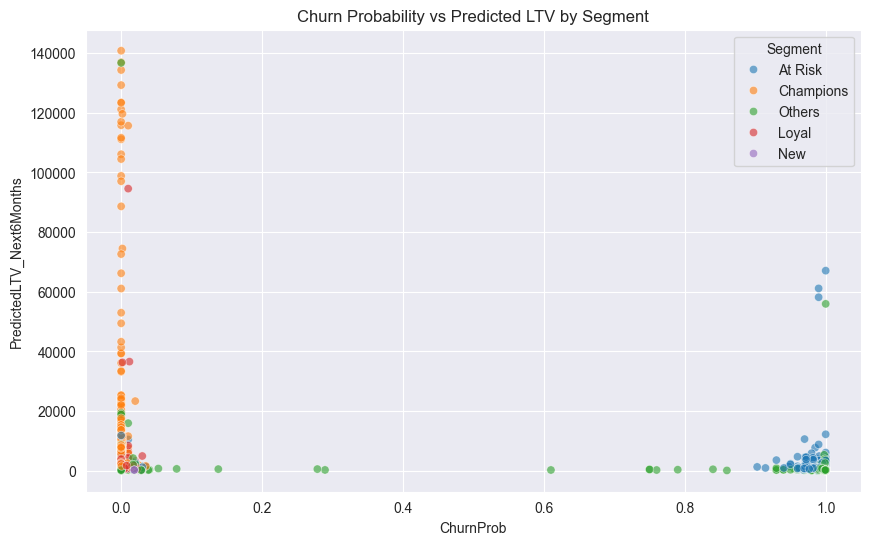

In [2]:
import sys
sys.path.append('..')
import importlib
import src.business.offer_recommender
importlib.reload(src.business.offer_recommender)

# Now import the functions
from src.business.offer_recommender import generate_offer_recommendations, create_marketing_campaign_summary
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.churn_model import load_model
from src.models.ltv_model import load_ltv_model
from src.utils.logger import setup_logger

logger = setup_logger('offer_recommendations')

# Load customer features with LTV
customers = pd.read_csv('../data/processed/customer_features_with_ltv.csv', index_col=0)

# Load churn model and add churn probabilities
churn_model = load_model('../models/churn_model_rf.pkl')

# We need to compute churn probabilities using the same feature columns as training
feature_cols = ['Recency', 'Frequency', 'Monetary', 'TenureDays', 'AvgOrderValue']
X_churn = customers[feature_cols]
customers['ChurnProb'] = churn_model.predict_proba(X_churn)[:, 1]

# Load LTV model (if needed for updated predictions) – but we already have PredictedLTV_Next6Months
# ltv_model = load_ltv_model('../models/ltv_model_rf.pkl')
# X_ltv = customers[feature_cols]  # same features
# customers['PredictedLTV_Next6Months'] = ltv_model.predict(X_ltv)  # optional update

# Generate offers
# Generate offers
customers_with_offers = generate_offer_recommendations(
    customers,
    churn_prob_col='ChurnProb',
    ltv_col='PredictedLTV_Next6Months',
    segment_col='Segment'
)

# Reset index to make CustomerID a column
customers_with_offers = customers_with_offers.reset_index()

# Save the final dataset with offers
customers_with_offers.to_csv('../data/processed/customers_with_offers.csv')
logger.info("Saved customers_with_offers.csv")

# Create campaign summary for marketing
campaign_summary = create_marketing_campaign_summary(customers_with_offers)
campaign_summary.to_csv('../reports/campaign_summary.csv', index=False)
logger.info("Saved campaign summary to reports/")

# Display summary
print("\n--- Campaign Summary ---")
print(campaign_summary)

# Visualize offer distribution
plt.figure(figsize=(12,6))
offer_counts = customers_with_offers['RecommendedOffer'].value_counts()
sns.barplot(x=offer_counts.values, y=offer_counts.index)
plt.title('Number of Customers per Offer Type')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig('../reports/offer_distribution.png')
plt.show()

# Optional: Segment vs ChurnProb vs LTV scatter
plt.figure(figsize=(10,6))
sns.scatterplot(data=customers_with_offers, x='ChurnProb', y='PredictedLTV_Next6Months', hue='Segment', alpha=0.6)
plt.title('Churn Probability vs Predicted LTV by Segment')
plt.savefig('../reports/segment_churn_ltv_scatter.png')
plt.show()